In [1]:
import os
import numpy as np
import librosa
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEARCH_DIR = "/kaggle/input/drone-data/dataset_windows"
MODEL_FILE = "drone_brain_v2.pkl"
SCALER_FILE = "feature_scaler.pkl"

# --- IMPROVED FEATURE EXTRACTION ---
def extract_advanced_features(file_path):
    """
    Extract multiple audio features for better classification
    """
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000, duration=3.0)  # Limit to 3 sec
        
        # Normalize audio
        audio = audio / (np.max(np.abs(audio)) + 1e-6)
        
        features = []
        
        # 1. MFCCs (Mel-frequency cepstral coefficients) - Your original
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)  # Reduced from 40
        mfccs_mean = np.mean(mfccs.T, axis=0)
        mfccs_std = np.std(mfccs.T, axis=0)
        features.extend(mfccs_mean)
        features.extend(mfccs_std)
        
        # 2. Spectral Features (capture frequency characteristics)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr))
        features.extend([spectral_centroid, spectral_rolloff, spectral_contrast])
        
        # 3. Zero Crossing Rate (noise vs tonal)
        zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
        features.append(zcr)
        
        # 4. Chroma Features (harmonic content)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
        features.extend(chroma)
        
        # 5. RMS Energy (overall loudness)
        rms = np.mean(librosa.feature.rms(y=audio))
        features.append(rms)
        
        return np.array(features)
        
    except Exception as e:
        print(f"⚠️  Error processing {file_path}: {e}")
        return None

In [3]:
def augment_audio(audio, sr=16000):
    """
    Create variations of audio for better generalization
    """
    augmented = []
    
    # Original
    augmented.append(audio)
    
    # 1. Add Gaussian noise (simulate environmental noise)
    noise = np.random.normal(0, 0.005, audio.shape)
    augmented.append(audio + noise)
    
    # 2. Time stretch (simulate speed variations)
    stretched = librosa.effects.time_stretch(audio, rate=0.9)
    if len(stretched) >= len(audio):
        augmented.append(stretched[:len(audio)])
    
    # 3. Pitch shift (simulate different drone types)
    shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    augmented.append(shifted)
    
    return augmented

In [5]:
def load_and_augment_data(search_dir, augment=True):
    """
    Load data with optional augmentation
    """
    features = []
    labels = []
    drone_count = 0
    noise_count = 0
    
    print("🔍 Scanning for audio files...")
    
    for root, dirs, files in os.walk(search_dir):
        for file in files:
            if file.endswith(".wav"):
                path = os.path.join(root, file)
                
                # Determine label
                filename = file.lower()
                folder_name = os.path.basename(root).lower()
                
                label = -1
                if "noise" in filename:
                    label = 0
                elif "drone" in filename:
                    label = 1
                elif "noise" in folder_name:
                    label = 0
                elif "drone" in folder_name:
                    label = 1
                
                if label != -1:
                    # Load audio
                    try:
                        audio, sr = librosa.load(path, sr=16000)
                        
                        # Augment if enabled
                        if augment:
                            audio_variants = augment_audio(audio, sr)
                        else:
                            audio_variants = [audio]
                        
                        # Extract features for each variant
                        for aug_audio in audio_variants:
                            feat = extract_advanced_features_from_array(aug_audio, sr)
                            if feat is not None:
                                features.append(feat)
                                labels.append(label)
                                
                                if label == 1: 
                                    drone_count += 1
                                else: 
                                    noise_count += 1
                    
                    except Exception as e:
                        print(f"⚠️  Skipped {file}: {e}")
                        continue
    
    print(f"✅ FOUND: {drone_count} Drone samples | {noise_count} Noise samples")
    return np.array(features), np.array(labels), drone_count, noise_count

In [6]:
def extract_advanced_features_from_array(audio, sr):
    """Extract features from audio array (for augmentation)"""
    try:
        audio = audio / (np.max(np.abs(audio)) + 1e-6)
        features = []
        
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        features.extend(np.mean(mfccs.T, axis=0))
        features.extend(np.std(mfccs.T, axis=0))
        
        features.append(np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr)))
        features.append(np.mean(librosa.feature.zero_crossing_rate(audio)))
        features.extend(np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1))
        features.append(np.mean(librosa.feature.rms(y=audio)))
        
        return np.array(features)
    except:
        return None

In [8]:
def optimize_model(X_train, y_train):
    """
    Find best Random Forest parameters
    """
    print("\n🔧 Running Hyperparameter Optimization...")
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(
        rf, 
        param_grid, 
        cv=5, 
        scoring='f1',
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ Best CV F1 Score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

🚁 ENHANCED DRONE DETECTION TRAINING
🔍 Scanning for audio files...
✅ FOUND: 400 Drone samples | 412 Noise samples

📊 Scaling features...

📈 Training Set: 649 samples
📈 Test Set: 163 samples

🎯 Training model with 5-fold cross-validation...

✅ Cross-Validation Accuracy: 0.9476 (+/- 0.0331)

🎯 Test Set Accuracy: 96.32%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Noise       0.98      0.95      0.96        83
       Drone       0.95      0.97      0.96        80

    accuracy                           0.96       163
   macro avg       0.96      0.96      0.96       163
weighted avg       0.96      0.96      0.96       163


🔍 Top 10 Most Important Features:
  1. Feature 1: 0.1171
  2. Feature 40: 0.1000
  3. Feature 41: 0.0818
  4. Feature 43: 0.0476
  5. Feature 2: 0.0424
  6. Feature 42: 0.0360
  7. Feature 8: 0.0331
  8. Feature 7: 0.0326
  9. Feature 20: 0.0294
  10. Feature 3: 0.0228


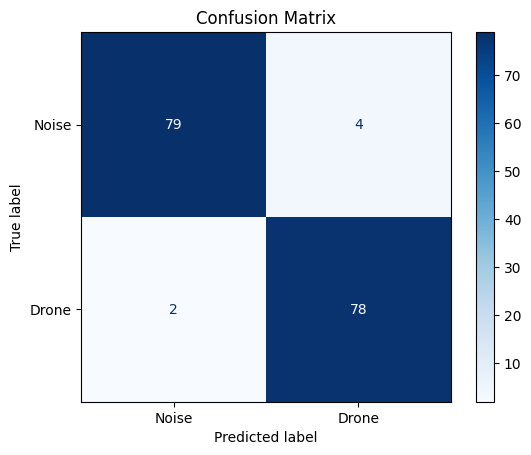


💾 Model saved as: drone_brain_v2.pkl
💾 Scaler saved as: feature_scaler.pkl

⚠️  IMPORTANT: Update your real-time script to:
   1. Load the scaler
   2. Use extract_advanced_features() function
   3. Scale features before prediction


In [9]:
def main():
    print("=" * 60)
    print("🚁 ENHANCED DRONE DETECTION TRAINING")
    print("=" * 60)
    
    # 1. Load data with augmentation
    X, y, drone_count, noise_count = load_and_augment_data(
        SEARCH_DIR, 
        augment=True  # Set to False for faster training
    )
    
    if len(X) < 20:
        print("❌ Not enough data! Need at least 20 samples.")
        return
    
    # 2. Feature Scaling (Important for consistent performance)
    print("\n📊 Scaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 3. Split data (stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    print(f"\n📈 Training Set: {len(X_train)} samples")
    print(f"📈 Test Set: {len(X_test)} samples")
    
    # 4. Train with cross-validation
    print("\n🎯 Training model with 5-fold cross-validation...")
    
    # Option A: Quick training (use default params)
    clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    
    # Option B: Optimized training (uncomment to use)
    # clf = optimize_model(X_train, y_train)
    
    # 5. Cross-validation scores
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n✅ Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # 6. Test set evaluation
    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    
    print(f"\n🎯 Test Set Accuracy: {test_acc*100:.2f}%")
    
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=["Noise", "Drone"]))
    
    # 7. Feature importance
    print("\n🔍 Top 10 Most Important Features:")
    feature_importance = clf.feature_importances_
    top_features = np.argsort(feature_importance)[-10:][::-1]
    for i, idx in enumerate(top_features, 1):
        print(f"  {i}. Feature {idx}: {feature_importance[idx]:.4f}")
    
    # 8. Save model and scaler
    joblib.dump(clf, MODEL_FILE)
    joblib.dump(scaler, SCALER_FILE)

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

     # Create predictions
    y_pred = clf.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Noise", "Drone"]
    )
    disp.plot(cmap="Blues", values_format="d")

    plt.title("Confusion Matrix")
    plt.savefig(
    "confusion_matrix_drone_detection.png",
    dpi=300,
    bbox_inches="tight"
    )

    plt.show()

    
    print(f"\n💾 Model saved as: {MODEL_FILE}")
    print(f"💾 Scaler saved as: {SCALER_FILE}")
    print("\n⚠️  IMPORTANT: Update your real-time script to:")
    print("   1. Load the scaler")
    print("   2. Use extract_advanced_features() function")
    print("   3. Scale features before prediction")
    
    return clf, scaler


if __name__ == "__main__":
    clf, scaler = main()

NameError: name 'X_test' is not defined